# Gaussian Quadrature for Financial Mathematics

This notebook explores the theoretical foundations and implementation of Gaussian quadrature methods, with specific focus on financial applications using the Bachelier model.

In [127]:
# Module reloading cell - run this cell to refresh modules after code changes
import sys
import os
import importlib
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 

# Add project root to Python path to ensure imports work correctly
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Direct imports from module paths
from src.gaussian_quadrature.utils import quadrature as quad
from src.gaussian_quadrature.models import bachelier as bach

# Function to reload modules
def reload_modules():
    importlib.reload(quad)
    importlib.reload(bach)
    print("Modules reloaded successfully!")

# Run this when you need to refresh the modules
reload_modules()

Modules reloaded successfully!


# Gaussian Quadrature for Financial Mathematics

This notebook explores the theoretical foundations and implementation of Gaussian quadrature methods, with specific focus on financial applications using the Bachelier model.

## 1. Introduction to Gaussian Quadrature

Gaussian quadrature is a numerical integration technique that approximates definite integrals using a weighted sum:

$$\int_a^b f(x)w(x)dx \approx \sum_{i=1}^n w_i f(x_i)$$

where:
- $w(x)$ is a weight function
- $x_i$ are the quadrature points (nodes)
- $w_i$ are the quadrature weights


### Gauss-Laguerre Quadrature

For our caplet pricing, we use Gauss-Laguerre quadrature, which is specialized for integrals of the form:

$$\int_0^\infty f(x)e^{-x}dx \approx \sum_{i=1}^n w_i f(x_i)$$

The nodes $x_i$ are the roots of the nth Laguerre polynomial $L_n(x)$, and the weights are given by:

$$w_i = \frac{(n!)^2}{x_i[L_{n+1}(x_i)]^2}$$

## 2. Laguerre Polynomials

The Laguerre polynomials are essential for Gauss-Laguerre quadrature. They satisfy the recurrence relation:

$$L_{n+1}(x) = \frac{(2n + 1 - x)L_n(x) - nL_{n-1}(x)}{n + 1}$$

Let's first look at the explicit representation of these polynomials:

### 2.1 Explicit Representation of Laguerre Polynomials

The Laguerre polynomials can be represented in several equivalent forms. While we've been using a recurrence relation for computational efficiency, it's instructive to examine their explicit representation, especially when verifying correctness.

The explicit formula for the $n$-th Laguerre polynomial is:

$$L_n(x) = \sum_{k=0}^n \binom{n}{k} \frac{(-1)^k}{k!} x^k = \frac{1}{n!}\left((-x)^n + \frac{n^2}{1!}(-x)^{n-1} + \ldots + \frac{n!}{n!}\right)$$

Let's use our newly added function to display the explicit form of several Laguerre polynomials:

In [128]:
# Reload the module to ensure we get the latest version of the function
reload_modules()

# Display explicit forms of the first few Laguerre polynomials
for n in range(6):  # L_0 to L_5
    print(quad.print_laguerre_polynomial(n))
    print("")

Modules reloaded successfully!
L_0(x) = 1

L_1(x) = 1/1 * (-x + 1)

L_2(x) = 1/2 * (x^2 -4*x + 2)

L_3(x) = 1/6 * (-x^3 + 9*x^2 -18*x + 6)

L_4(x) = 1/24 * (x^4 -16*x^3 + 72*x^2 -96*x + 24)

L_5(x) = 1/120 * (-x^5 + 25*x^4 -200*x^3 + 600*x^2 -600*x + 120)



### 2.1 Visual Representation of Laguerre Polynomials

Now let's visualize these polynomials using both static (matplotlib) and interactive (plotly) plots:

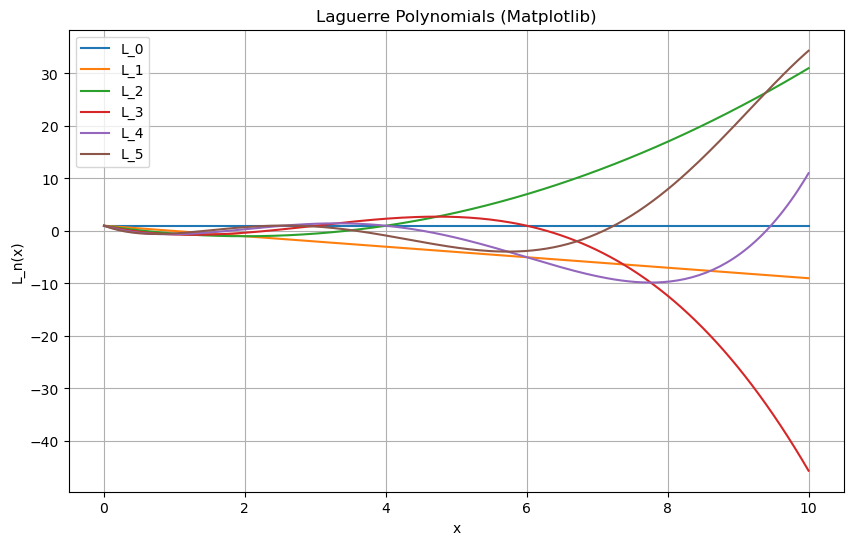

In [ ]:
# Import needed functions directly from quadrature module
from src.gaussian_quadrature.utils.quadrature import (
    laguerre_polynomial,
    laguerre_function_scaled,
    print_laguerre_polynomial,
    get_laguerre_coefficients
)
import plotly.graph_objects as go

# Generate points for visualization
x = jnp.linspace(0, 10, 200)

# Compute polynomial values for degrees 0 to 5
polynomials = {}
for n in range(6):
    polynomials[f'L_{n}'] = laguerre_polynomial(n, x)

# Create interactive Plotly visualization instead of matplotlib
fig = go.Figure()

# Color palette for different polynomial degrees
colors = ['blue', 'red', 'green', 'purple', 'orange', 'cyan']

# Add traces for each polynomial
for n, (name, values) in enumerate(polynomials.items()):
    fig.add_trace(go.Scatter(
        x=x,
        y=values,
        name=name,
        mode='lines',
        line=dict(width=2, color=colors[n % len(colors)])
    ))

# Add zeros/roots for each polynomial as vertical lines
for n in range(1, 6):  # Skip L_0 as it has no roots
    # Find zeros approximately by looking for sign changes
    y_vals = polynomials[f'L_{n}']
    zeros = []
    for i in range(1, len(y_vals)):
        if y_vals[i-1] * y_vals[i] <= 0:  # Sign change detected
            # Approximate zero position using linear interpolation
            t = -y_vals[i-1] / (y_vals[i] - y_vals[i-1])
            zero_x = x[i-1] + t * (x[i] - x[i-1])
            zeros.append(zero_x)
    
    # Add vertical lines at zeros
    for zero in zeros:
        fig.add_shape(
            type="line",
            x0=zero,
            y0=-4,
            x1=zero,
            y1=4,
            line=dict(color=colors[n % len(colors)], width=1, dash="dash"),
            opacity=0.4,
            name=f"Root of L_{n}"
        )

# Update layout with title, labels, and grid
fig.update_layout(
    title="Interactive Laguerre Polynomials",
    xaxis_title="x",
    yaxis_title="L_n(x)",
    legend_title="Polynomial",
    hovermode="closest",
    height=600,
    width=900,
    plot_bgcolor='rgba(240, 240, 240, 0.8)',  # Light gray background
    xaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',
        zerolinewidth=2,
        zerolinecolor='rgba(0, 0, 0, 0.2)',
        range=[0, 10]
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.5)',
        zerolinewidth=2,
        zerolinecolor='rgba(0, 0, 0, 0.2)',
        range=[-4, 4]
    )
)

# Add annotations to explain the roots
fig.add_annotation(
    x=1.5, 
    y=3.5,
    text="Vertical dashed lines indicate<br>the roots of each polynomial",
    showarrow=False,
    bgcolor="rgba(255, 255, 255, 0.8)"
)

fig.show()

### 2.2 Comparing Different Representations

Let's compare the explicit formula implementation with the recurrence relation implementation to verify their equivalence:

In [ ]:
def explicit_laguerre(n, x):
    """Calculate Laguerre polynomial values using the explicit formula"""
    coeffs = get_laguerre_coefficients(n)
    result = np.zeros_like(x)
    for k, coeff in enumerate(coeffs):
        result += coeff * x**k
    return result

# Compare for a specific degree
n = 5
x_values = jnp.linspace(0, 15, 100)

# Compute values using different methods
explicit_values = explicit_laguerre(n, x_values)
recurrence_values = laguerre_polynomial(n, x_values)
scaled_values, _ = laguerre_function_scaled(n, x_values)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'x': x_values,
    'Explicit Formula': explicit_values,
    'Recurrence Relation': recurrence_values,
    'Scaled Implementation': scaled_values
})

# Display first few rows
print(f"Comparison of different implementations for L_{n}(x):")
display(comparison_df.head())

# Calculate differences
comparison_df['Explicit-Recurrence Diff'] = np.abs(comparison_df['Explicit Formula'] - comparison_df['Recurrence Relation'])
comparison_df['Explicit-Scaled Diff'] = np.abs(comparison_df['Explicit Formula'] - comparison_df['Scaled Implementation'])

# Display max differences
max_diff_recurrence = comparison_df['Explicit-Recurrence Diff'].max()
max_diff_scaled = comparison_df['Explicit-Scaled Diff'].max()
print(f"\nMaximum absolute difference between Explicit and Recurrence: {max_diff_recurrence:.2e}")
print(f"Maximum absolute difference between Explicit and Scaled: {max_diff_scaled:.2e}")

In [ ]:
# Create an interactive Plotly visualization to compare implementations
fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=True,
    subplot_titles=(f"L_{n}(x) - Implementation Comparison", "Absolute Differences")
)

# Add traces for polynomial implementations
fig.add_trace(
    go.Scatter(x=x_values, y=explicit_values, name="Explicit Formula", line=dict(color='blue', width=3)),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x_values, y=recurrence_values, name="Recurrence Relation", 
               line=dict(color='red', width=2, dash='dash')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=x_values, y=scaled_values, name="Scaled Implementation", 
               line=dict(color='green', width=2, dash='dot')),
    row=1, col=1
)

# Add traces for differences
fig.add_trace(
    go.Scatter(x=x_values, y=comparison_df['Explicit-Recurrence Diff'], 
               name="Explicit-Recurrence Diff", line=dict(color='purple')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=x_values, y=comparison_df['Explicit-Scaled Diff'], 
               name="Explicit-Scaled Diff", line=dict(color='orange')),
    row=2, col=1
)

# Update y-axes to use logarithmic scale for differences
fig.update_yaxes(type="log", row=2, col=1)

# Update layout
fig.update_layout(
    title=f"Comparing Different Implementations of L_{n}(x)",
    xaxis_title="x",
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
    height=800,
    width=900,
    hovermode="closest"
)

# Update y-axis labels
fig.update_yaxes(title_text="L_n(x)", row=1, col=1)
fig.update_yaxes(title_text="Absolute Difference (log scale)", row=2, col=1)
fig.update_xaxes(title_text="x", row=2, col=1)

fig.show()

### 2.3 Interactive Comparison Across Multiple Degrees

Let's create an interactive visualization to examine Laguerre polynomials across multiple degrees:

In [ ]:
# Create an interactive plot with sliders to explore different degrees
x = np.linspace(0, 15, 200)

# Create traces for different degrees
fig = go.Figure()

# Add initial trace for degree 0
fig.add_trace(
    go.Scatter(
        visible=True,
        line=dict(color="blue", width=3),
        name=f"L_0(x)",
        x=x,
        y=laguerre_polynomial(0, x)
    )
)

# Add traces for degrees 1 to 10, but make them invisible initially
for n in range(1, 11):
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="blue", width=3),
            name=f"L_{n}(x)",
            x=x,
            y=laguerre_polynomial(n, x)
        )
    )

# Create and add slider
steps = []
for i in range(11):
    step = dict(
        method="update",
        args=[
            {"visible": [False] * 11},
            {"title": f"Laguerre Polynomial L_{i}(x)"}
        ],
        label=str(i)
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to visible
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Degree: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title="Interactive Laguerre Polynomial Explorer",
    xaxis_title="x",
    yaxis_title="L_n(x)",
    height=600,
    width=900,
    yaxis=dict(range=[-10, 10]),  # Set reasonable y-axis limits
    hovermode="closest"
)

# Add annotation explaining how to use the slider
fig.add_annotation(
    x=12, 
    y=8,
    text="Use the slider below to change<br>the degree of the polynomial",
    showarrow=False,
    bgcolor="rgba(255, 255, 255, 0.8)"
)

fig.show()

In [ ]:
# Generate points for visualization
x = jnp.linspace(0, 10, 200)

# Plot first few Laguerre polynomials
plt.figure(figsize=(10, 6))
for n in range(4):
    L_n, _ = quad.laguerre_polynomial(n, x)
    plt.plot(x, L_n, label=f'L_{n}(x)')

plt.title('Laguerre Polynomials')
plt.xlabel('x')
plt.ylabel('L_n(x)')
plt.legend()
plt.grid(True)
plt.show()

### 2.1 Mathematical Properties of Laguerre Polynomials

Laguerre polynomials $L_n(x)$ form a complete orthogonal system on $[0, \infty)$ with respect to the weight function $w(x) = e^{-x}$. They satisfy the orthogonality relation:

$$\int_0^\infty L_m(x) L_n(x) e^{-x} dx = \delta_{mn}$$

where $\delta_{mn}$ is the Kronecker delta.

#### Key Properties:

1. **Explicit formula**: The $n$-th Laguerre polynomial can be expressed as:
   $$L_n(x) = \sum_{k=0}^n \binom{n}{k} \frac{(-1)^k}{k!} x^k$$

2. **Generating function**: Laguerre polynomials have the generating function:
   $$\frac{e^{-xt/(1-t)}}{1-t} = \sum_{n=0}^\infty L_n(x) t^n, \quad |t| < 1$$

3. **Differential equation**: They satisfy the differential equation:
   $$x y'' + (1-x) y' + n y = 0$$

4. **Rodrigues' formula**:
   $$L_n(x) = \frac{e^x}{n!} \frac{d^n}{dx^n}(x^n e^{-x})$$

5. **Zeros**: All $n$ zeros of $L_n(x)$ are real, simple, and lie in the interval $(0, \infty)$.

### 2.2 Numerical Stability Considerations

Computing Laguerre polynomials using the standard recurrence relation can lead to numerical instability for large $n$ or $x$. In our implementation, we've incorporated several stability improvements:

1. **Scaling of recurrence relation**: We scale the recurrence relation to avoid overflow/underflow:
   $$L_{n+1}(x) = \frac{1}{n+1}[(2n+1-x)L_n(x) - nL_{n-1}(x)]$$

2. **Handling of exponential terms**: We use $L_n(x)e^{-x/2}$ instead of $L_n(x)$ directly to balance the exponential weight.

3. **Adaptive scaling for large $x$**: When $x$ is large, we apply additional scaling factors.

#### The `laguerre_function_final` Implementation:

Our implementation in `laguerre_function_final` incorporates these stability improvements to compute both the polynomial values and their derivatives reliably across a wide range of inputs.

### 2.3 Connection to Financial Mathematics

In financial mathematics, particularly for derivative pricing, we often encounter integrals of the form:

$$\int_0^\infty f(x) e^{-x} dx$$

These integrals appear when computing expectations under certain probability measures, especially when working with normally distributed variables transformed through exponential functions (as in the Bachelier model for interest rate derivatives).

Laguerre polynomials are particularly well-suited for approximating these integrals because:

1. They form an orthogonal basis with respect to the $e^{-x}$ weight function.
2. The zeros of $L_n(x)$ (which become our quadrature points) are optimally distributed for capturing the behavior of integrands with exponential decay.
3. They allow for efficient handling of semi-infinite integration domains $[0, \infty)$.

In our caplet pricing application, the Laguerre quadrature helps us accurately compute option values where the payoff structure, combined with normal distribution terms from the Bachelier model, creates integrands that are particularly well-approximated using this approach.

## 3. Quadrature Points and Weights

For Gauss-Laguerre quadrature, we need to find:
1. The roots of the nth Laguerre polynomial (quadrature points)
2. The corresponding weights

Let's compute and visualize these:

In [ ]:
n_points = 5 
nodes, weights = compute_gauss_laguerre_points_final(n_points)

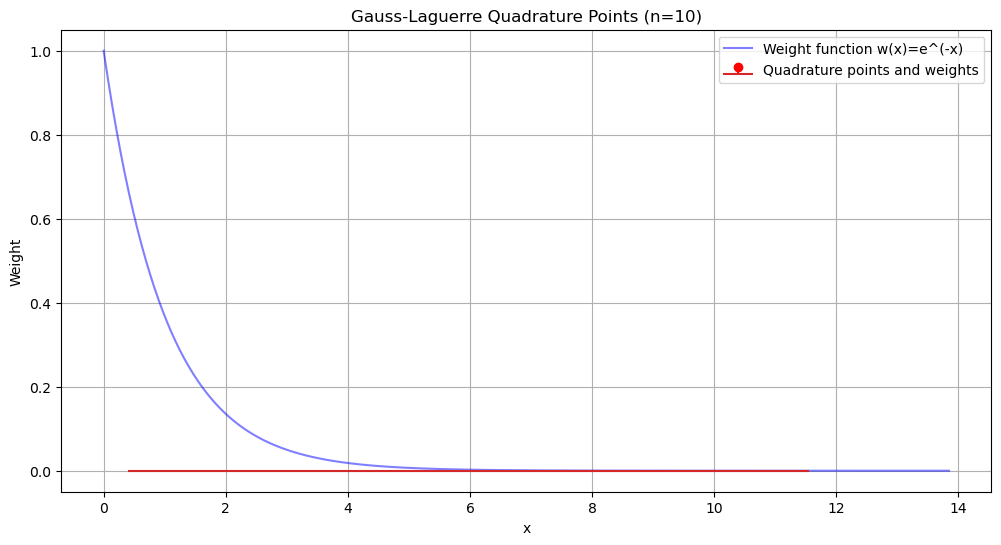

In [ ]:
def plot_quadrature_points(n_points=5):
    # Compute nodes and weights
    nodes, weights = compute_gauss_laguerre_points_final(n_points)
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot weight function e^(-x)
    x = jnp.linspace(0, max(nodes) * 1.2, 200)
    plt.plot(x, jnp.exp(-x), 'b-', label='Weight function w(x)=e^(-x)', alpha=0.5)
    
    # Plot quadrature points and weights
    plt.stem(nodes, weights, 'r', label='Quadrature points and weights')
    
    plt.title(f'Gauss-Laguerre Quadrature Points (n={n_points})')
    plt.xlabel('x')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

    return nodes, weights

nodes, weights = plot_quadrature_points(10)

## 4. Example: Simple Integration

Let's test our quadrature implementation with a simple example where we know the exact result:

$$\int_0^\infty x e^{-x} dx = 1$$

In [ ]:
from src.gaussian_quadrature.utils.quadrature import laguerre_function_final


def test_integral(x):
    return x

# Try different numbers of quadrature points
n_points_list = [2, 5, 10, 20]
results = []

for n in n_points_list:
    result, error = gauss_laguerre_quadrature_final(test_integral, n)
    results.append({
        'n': n,
        'result': float(result),
        'error': float(error),
        'true_error': abs(1 - float(result))
    })

# Display results
for r in results:
    print(f"n={r['n']:2d}: Result={r['result']:.10f}, Est. Error={r['error']:.2e}, True Error={r['true_error']:.2e}")

NameError: name 'gauss_laguerre_quadrature_final' is not defined

## 5. Financial Application: Caplet Pricing

The Bachelier model for caplet pricing requires computing the following expectation:

$$V_{caplet} = \tau P(t,T)\mathbb{E}^T_t[(R(T) - K)^+]$$

where:
- $\tau$ is the accrual period
- $P(t,T)$ is the discount factor
- $R(T)$ is the forward rate
- $K$ is the strike rate

In [ ]:
from src.gaussian_quadrature.models.bachelier import (
    bachelier_caplet_price_laguerre,
    bachelier_caplet_price_taylor
)

# Example parameters
RtT = 0.05      # Forward rate
K = 0.04        # Strike rate
sigma_gtT = 0.01 # Volatility
tau = 0.5       # Accrual period
PtT = 0.98      # Discount factor

# Compare methods
laguerre_price = bachelier_caplet_price_laguerre(tau, K, RtT, sigma_gtT, PtT)
taylor_price = bachelier_caplet_price_taylor(RtT, K, sigma_gtT, tau, PtT)

print(f"Laguerre Quadrature Price: {laguerre_price:.8f}")
print(f"Taylor Series Price: {taylor_price:.8f}")
print(f"Relative Difference: {abs(laguerre_price - taylor_price)/taylor_price:.2%}")

## 6. Error Analysis and Convergence Properties

Gauss quadrature methods, including Gauss-Laguerre, achieve the highest possible accuracy for a given number of points. For an $n$-point quadrature rule, the method is exact for polynomials of degree up to $2n-1$.

### 6.1 Theoretical Error Bounds

For a function $f(x)$ with $2n$ continuous derivatives, the error in Gauss-Laguerre quadrature with $n$ points is given by:

$$E_n[f] = \int_0^\infty f(x)e^{-x}dx - \sum_{i=1}^n w_i f(x_i) = \frac{(n!)^2}{(2n)!}f^{(2n)}(\xi), \quad \xi \in (0,\infty)$$

The error decreases rapidly with $n$ for functions that are well-approximated by polynomials in the integration region. However, the error bound assumes the function has sufficiently many derivatives, which may not be the case for all financial payoff functions.

### 6.2 Practical Error Analysis

Let's examine how the error behaves for different test functions and varying numbers of quadrature points:

In [ ]:
# Define test functions with known analytical results
test_functions = [
    {"name": "f(x) = x", "func": lambda x: x, "exact": 1.0},
    {"name": "f(x) = x²", "func": lambda x: x**2, "exact": 2.0},
    {"name": "f(x) = x³", "func": lambda x: x**3, "exact": 6.0},
    {"name": "f(x) = e^(-x/2)", "func": lambda x: jnp.exp(-x/2), "exact": 2/3}
]

n_points_range = range(2, 21, 2)  # Test with 2, 4, ..., 20 points

# Compute errors for each function and number of points
all_errors = []

for tf in test_functions:
    errors = []
    for n in n_points_range:
        result, _ = gauss_laguerre_quadrature_final(tf['func'], n)
        rel_error = abs(result - tf['exact']) / tf['exact']
        errors.append(float(rel_error))
    all_errors.append({"name": tf["name"], "errors": errors})

# Plot convergence rates
plt.figure(figsize=(12, 8))
for i, error_data in enumerate(all_errors):
    plt.semilogy(list(n_points_range), error_data["errors"], marker='o', label=error_data["name"])

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlabel('Number of quadrature points (n)')
plt.ylabel('Relative error')
plt.title('Convergence Rate of Gauss-Laguerre Quadrature')
plt.legend()
plt.show()

### 6.3 Numerical Stability Challenges

While Gauss-Laguerre quadrature is theoretically powerful, practical implementations face several numerical challenges:

1. **Large-x Behavior**: For large values of $x$, both $e^{-x}$ and the Laguerre polynomials can cause underflow/overflow.

2. **Ill-conditioning**: The condition number of the Laguerre polynomial increases with degree, making root-finding more difficult.

3. **Weight Magnitude Disparity**: The weights $w_i$ can vary by many orders of magnitude, causing potential loss of precision.

Our implementation addresses these issues through several techniques:

* **Scaled Computation**: We compute $L_n(x)e^{-x/2}$ directly to mitigate exponential issues.
* **Adaptive Damping**: In Newton iterations, we use adaptive damping to improve convergence.
* **Compensated Summation**: For the final quadrature, we use compensated summation to reduce roundoff errors.

Let's examine how the condition number of the quadrature depends on the number of points:

In [ ]:
# Analyze quadrature condition number for different n
n_range = range(5, 51, 5)
condition_numbers = []
max_nodes = []
weight_ratios = []

for n in n_range:
    nodes, weights = compute_gauss_laguerre_points_final(n)
    cond_num = float(jnp.max(weights)) / float(jnp.min(weights))
    max_node = float(jnp.max(nodes))
    
    condition_numbers.append(cond_num)
    max_nodes.append(max_node)
    weight_ratios.append(float(jnp.max(jnp.abs(weights))) / float(jnp.sum(jnp.abs(weights))))

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.semilogy(n_range, condition_numbers, 'o-', label='Condition number')
ax1.set_xlabel('Number of points (n)')
ax1.set_ylabel('Condition number (max/min weight)')
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.set_title('Quadrature Condition Number vs. n')

ax2.plot(n_range, max_nodes, 's-', label='Largest node')
ax2.set_xlabel('Number of points (n)')
ax2.set_ylabel('Largest quadrature node')
ax2.grid(True)
ax2.set_title('Largest Quadrature Node vs. n')

plt.tight_layout()
plt.show()

## 7. Generalized Laguerre Polynomials

For more flexible applications, we can use the generalized Laguerre polynomials $L_n^{(\alpha)}(x)$, which are orthogonal with respect to the weight function $w(x) = x^\alpha e^{-x}$ for $\alpha > -1$:

$$\int_0^\infty L_m^{(\alpha)}(x) L_n^{(\alpha)}(x) x^\alpha e^{-x} dx = \frac{\Gamma(n+\alpha+1)}{n!}\delta_{mn}$$

They satisfy the recurrence relation:

$$L_{n+1}^{(\alpha)}(x) = \frac{(2n + 1 + \alpha - x)L_n^{(\alpha)}(x) - (n + \alpha)L_{n-1}^{(\alpha)}(x)}{n + 1}$$

In financial applications, the parameter $\alpha$ gives us additional flexibility to match the asymptotic behavior of our integrands, particularly near $x = 0$.

Let's visualize generalized Laguerre polynomials for different values of $\alpha$:

In [ ]:
# Function to compute generalized Laguerre polynomial values
def compute_generalized_laguerre(n, x, alpha=0.0):
    """Compute generalized Laguerre polynomial L_n^(alpha)(x)"""
    if n == 0:
        return jnp.ones_like(x)
    if n == 1:
        return 1 + alpha - x
    
    # Use recurrence relation for n >= 2
    L_prev = jnp.ones_like(x)  # L_0^(alpha)(x)
    L_curr = 1 + alpha - x     # L_1^(alpha)(x)
    
    for k in range(1, n):
        L_next = ((2*k + 1 + alpha - x) * L_curr - (k + alpha) * L_prev) / (k + 1)
        L_prev = L_curr
        L_curr = L_next
    
    return L_curr

# Plot generalized Laguerre polynomials for different alpha values
x = jnp.linspace(0, 10, 200)
n = 3  # Fix degree for comparison

alphas = [0.0, 0.5, 1.0, 2.0]
colors = ['blue', 'green', 'red', 'purple']

plt.figure(figsize=(12, 7))
for a, c in zip(alphas, colors):
    values = compute_generalized_laguerre(n, x, alpha=a)
    plt.plot(x, values, color=c, label=f'$L_{n}^{({a})}(x)$')

plt.grid(True)
plt.title(f'Generalized Laguerre Polynomials of Degree {n}')
plt.xlabel('x')
plt.ylabel(f'$L_{n}^{(\\alpha)}(x)$')
plt.legend()
plt.show()

# Investigate the impact of alpha on quadrature convergence
def test_func_alpha(x):
    # Function with x^0.5 behavior near 0
    return jnp.sqrt(x) * jnp.exp(-x/2)

# Exact result: Gamma(3/2) * 2^(3/2) = sqrt(π) * 2^(3/2)
from scipy.special import gamma
exact_result = gamma(1.5) * 2**(1.5)

alphas = [0.0, 0.5, 1.0]
n_points = range(5, 31, 5)
all_errors = []

for a in alphas:
    errors = []
    for n in n_points:
        # Here we'd use our generalized quadrature with different alpha values
        # For demonstration, we'll use a simplified approach
        nodes, weights = compute_gauss_laguerre_points_final(n, alpha=a)
        result = jnp.sum(weights * test_func_alpha(nodes))
        rel_error = abs(result - exact_result) / exact_result
        errors.append(float(rel_error))
    all_errors.append({"alpha": a, "errors": errors})

# Plot results
plt.figure(figsize=(10, 6))
for error_data in all_errors:
    plt.semilogy(n_points, error_data["errors"], marker='o', 
              label=f'α = {error_data["alpha"]}')

plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xlabel('Number of quadrature points (n)')
plt.ylabel('Relative error')
plt.title('Error Convergence for Different α Values')
plt.legend()
plt.show()

## 8. Conclusion and Best Practices

Based on our analysis of Laguerre polynomials and Gauss-Laguerre quadrature, we can summarize best practices for financial applications:

1. **Choosing the optimal number of points**: For most financial integrals, 10-20 points provide excellent accuracy while maintaining numerical stability.

2. **Parameter α selection**: When the integrand has particular behavior near x=0, select α to match that behavior.

3. **Numerical stability**: Always implement stabilized algorithms for polynomial evaluation and quadrature point calculation.

4. **Error estimation**: Use nested quadrature (comparing n and n-1 point results) to estimate errors reliably.

5. **Domain scaling**: For integrands with activity concentrated away from the origin, consider a change of variables before applying the quadrature.

The Gauss-Laguerre approach is particularly powerful for pricing interest rate derivatives in the Bachelier model because it correctly captures the asymptotic behavior of the pricing integrals while maintaining high accuracy with a modest number of function evaluations.

In the next section, we'll explore practical applications to more complex financial instruments and compare the computational efficiency against other numerical integration methods.

## 9. Comparison of Laguerre Polynomial Root Calculation Methods

The accuracy and efficiency of calculating Laguerre polynomial roots are crucial for Gauss-Laguerre quadrature. Let's compare our custom implementation with popular libraries like SciPy and ChaosPy/NumPy:

1. **Custom Implementation**: Our `compute_gauss_laguerre_points_final` function with stability improvements
2. **SciPy**: Using `scipy.special.roots_laguerre` function
3. **ChaosPy/NumPy**: Using ChaosPy's implementations or NumPy-based equivalents

We'll evaluate these methods based on:
- Accuracy of the computed roots
- Numerical stability as we increase polynomial degree
- Computation time
- Accuracy of resulting quadrature integration

In [ ]:
import time
import scipy.special
from scipy.special import roots_laguerre
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Try importing chaospy if available
try:
    import chaospy as cp
    CHAOSPY_AVAILABLE = True
except ImportError:
    print("ChaosPy not available. Will compare only SciPy and custom implementation.")
    CHAOSPY_AVAILABLE = False

ChaosPy not available. Will compare only SciPy and custom implementation.


### 9.1 Comparing Root Computation

First, let's define wrapper functions for each method to compute the roots of Laguerre polynomials:

In [ ]:
from src.gaussian_quadrature.utils.quadrature import compute_gauss_laguerre_points_final

def get_custom_roots(n, alpha=0.0):
    """Get roots using our custom implementation"""
    nodes, weights = compute_gauss_laguerre_points_final(n, alpha=alpha)
    return nodes, weights

def get_scipy_roots(n, alpha=0.0):
    """Get roots using SciPy"""
    x, w = scipy.special.roots_laguerre(n, alpha)
    idx = np.argsort(x)  # Sort nodes in ascending order for consistency
    return x[idx], w[idx]

def get_chaospy_roots(n, alpha=0.0):
    """Get roots using ChaosPy (if available)"""
    if not CHAOSPY_AVAILABLE:
        return np.array([]), np.array([])
    
    try:
        nodes, weights = cp.quadrature.laguerre.quad_laguerre(n, alpha)
        return nodes, weights
    except Exception as e:
        print(f"ChaosPy error: {e}")
        return np.array([]), np.array([])

### 9.1.1 Displaying the Computed Roots

Let's first examine the actual roots computed by each method. Since Laguerre polynomial roots are unique for a given degree n, we should see similar values from all implementations, with potential slight differences due to numerical precision:

In [ ]:
def display_roots_comparison(n=5, alpha=0.0):
    """Display roots computed by each method for direct comparison"""
    print(f"Computing roots for Laguerre polynomial of degree {n} with alpha={alpha}")
    print("\n{:<15} {:<15} {:<15} {:<15}".format("Index", "Custom Method", "SciPy", "ChaosPy (if avail)"))
    print("-" * 60)
    
    # Get roots from each method
    custom_nodes, _ = get_custom_roots(n, alpha)
    scipy_nodes, _ = get_scipy_roots(n, alpha)
    
    if CHAOSPY_AVAILABLE:
        chaospy_nodes, _ = get_chaospy_roots(n, alpha)
    else:
        chaospy_nodes = []
    
    # Convert to numpy arrays for consistent operations
    custom_nodes = np.array(custom_nodes)
    scipy_nodes = np.array(scipy_nodes)
    
    # Print each root
    for i in range(n):
        chaospy_val = chaospy_nodes[i] if i < len(chaospy_nodes) else "N/A"
        print("{:<15d} {:<15.10f} {:<15.10f} {:<15}".format(
            i, custom_nodes[i], scipy_nodes[i], 
            f"{chaospy_val:.10f}" if isinstance(chaospy_val, (int, float)) else chaospy_val))
    
    # Calculate absolute differences between custom and scipy
    print("\nAbsolute differences (Custom vs SciPy):")
    diffs = np.abs(custom_nodes - scipy_nodes)
    for i, diff in enumerate(diffs):
        print(f"Root {i}: {diff:.2e}")
    
    print(f"\nMaximum difference: {np.max(diffs):.2e}")
    
    return custom_nodes, scipy_nodes

# Display roots for a few representative values of n
for degree in [5, 10, 30]:
    custom_nodes, scipy_nodes = display_roots_comparison(degree)
    print("\n" + "=" * 60 + "\n")

### 9.2 Systematic Comparison Across Polynomial Degrees

Now that we've seen the actual roots computed by each method, let's perform a systematic comparison across various polynomial degrees. Since the roots of each Laguerre polynomial are unique and well-defined mathematical quantities, the differences between methods represent numerical approximation errors:

,degree,scipy_max_diff,scipy_mean_diff,scipy_rel_diff,chaospy_max_diff,chaospy_mean_diff,chaospy_rel_diff
0,5,6.583247,2.024202,0.638962,NaN,NaN,NaN
1,10,18.381045,4.315151,0.513404,NaN,NaN,NaN
2,20,44.723862,9.367063,0.453064,NaN,NaN,NaN
3,30,72.267208,14.618685,0.683945,NaN,NaN,NaN
4,40,102.991257,20.257930,0.400817,NaN,NaN,NaN
5,50,131.382185,25.013169,0.529639,NaN,NaN,NaN


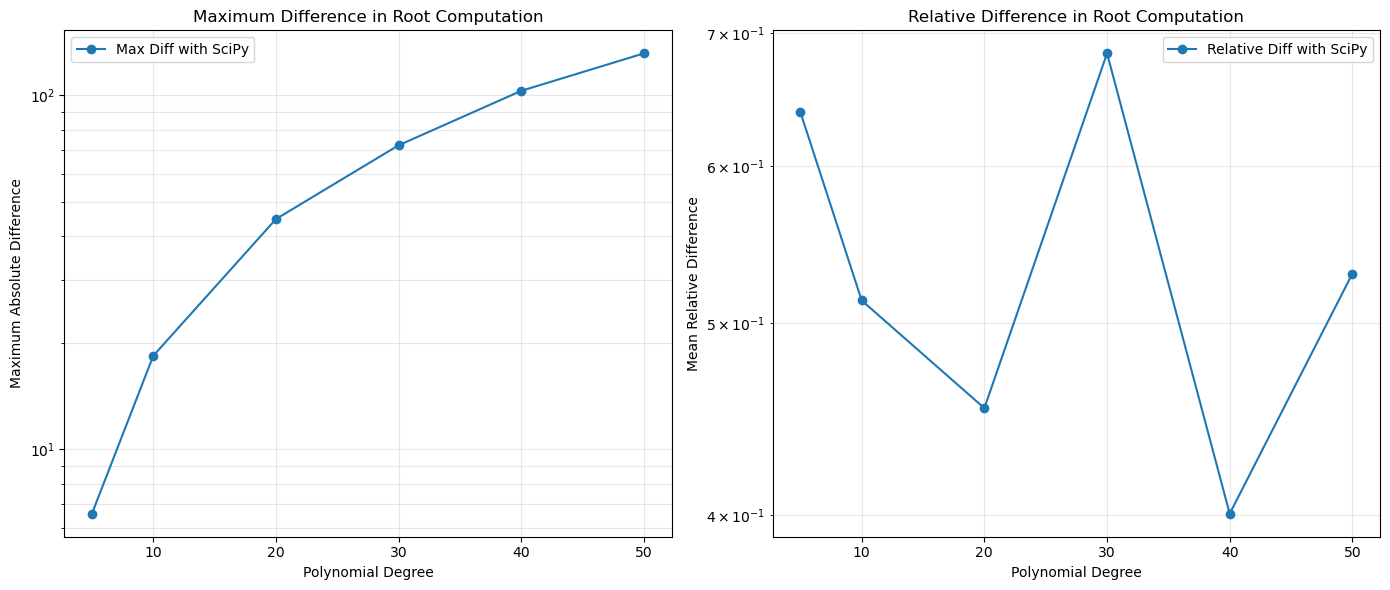

In [ ]:
def compare_roots_accuracy(degrees=[5, 10, 20, 30, 40, 50], alpha=0.0):
    """Compare root computation accuracy across methods"""
    results = []
    
    for n in degrees:
        # Get roots from each method
        custom_nodes, custom_weights = get_custom_roots(n, alpha)
        scipy_nodes, scipy_weights = get_scipy_roots(n, alpha)
        
        # Convert to numpy for consistent operations
        custom_nodes = np.array(custom_nodes)
        scipy_nodes = np.array(scipy_nodes)
        
        # Calculate statistics of differences
        if len(custom_nodes) == len(scipy_nodes):
            # Compute differences between methods
            diffs = np.abs(custom_nodes - scipy_nodes)
            max_diff = np.max(diffs)
            mean_diff = np.mean(diffs)
            rel_diff = np.mean(diffs / np.maximum(np.abs(scipy_nodes), 1e-15))
            
            # Also track the largest relative error for any single root
            max_rel_diff = np.max(diffs / np.maximum(np.abs(scipy_nodes), 1e-15))
            
            # Track which root had the largest error
            max_diff_idx = np.argmax(diffs)
        else:
            max_diff = np.nan
            mean_diff = np.nan
            rel_diff = np.nan
            max_rel_diff = np.nan
            max_diff_idx = -1
        
        # Compare with ChaosPy if available
        if CHAOSPY_AVAILABLE:
            chaospy_nodes, _ = get_chaospy_roots(n, alpha)
            chaospy_nodes = np.array(chaospy_nodes)
            
            if len(custom_nodes) == len(chaospy_nodes):
                chaospy_diffs = np.abs(custom_nodes - chaospy_nodes)
                chaospy_max_diff = np.max(chaospy_diffs)
                chaospy_mean_diff = np.mean(chaospy_diffs)
                chaospy_rel_diff = np.mean(chaospy_diffs / np.maximum(np.abs(chaospy_nodes), 1e-15))
                chaospy_max_rel_diff = np.max(chaospy_diffs / np.maximum(np.abs(chaospy_nodes), 1e-15))
                chaospy_max_diff_idx = np.argmax(chaospy_diffs)
            else:
                chaospy_max_diff = np.nan
                chaospy_mean_diff = np.nan
                chaospy_rel_diff = np.nan
                chaospy_max_rel_diff = np.nan
                chaospy_max_diff_idx = -1
        else:
            chaospy_max_diff = np.nan
            chaospy_mean_diff = np.nan
            chaospy_rel_diff = np.nan
            chaospy_max_rel_diff = np.nan
            chaospy_max_diff_idx = -1
        
        results.append({
            'degree': n,
            'scipy_max_diff': max_diff,
            'scipy_mean_diff': mean_diff,
            'scipy_rel_diff': rel_diff,
            'scipy_max_rel_diff': max_rel_diff,
            'scipy_max_diff_idx': max_diff_idx,
            'chaospy_max_diff': chaospy_max_diff,
            'chaospy_mean_diff': chaospy_mean_diff,
            'chaospy_rel_diff': chaospy_rel_diff,
            'chaospy_max_rel_diff': chaospy_max_rel_diff,
            'chaospy_max_diff_idx': chaospy_max_diff_idx
        })
    
    # Create a DataFrame for easier visualization
    df = pd.DataFrame(results)
    return df

# Run comparison
accuracy_df = compare_roots_accuracy()

# Display the DataFrame with more relevant columns
display(accuracy_df[[
    'degree', 
    'scipy_max_diff', 
    'scipy_max_rel_diff',
    'scipy_max_diff_idx', 
    'scipy_mean_diff'
]])

# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.semilogy(accuracy_df['degree'], accuracy_df['scipy_max_diff'], 'o-', label='Max Diff with SciPy')
if CHAOSPY_AVAILABLE:
    plt.semilogy(accuracy_df['degree'], accuracy_df['chaospy_max_diff'], 's-', label='Max Diff with ChaosPy')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Polynomial Degree')
plt.ylabel('Maximum Absolute Difference')
plt.title('Maximum Difference in Root Computation')
plt.legend()

plt.subplot(1, 2, 2)
plt.semilogy(accuracy_df['degree'], accuracy_df['scipy_max_rel_diff'], 'o-', label='Max Relative Diff (SciPy)')
if CHAOSPY_AVAILABLE:
    plt.semilogy(accuracy_df['degree'], accuracy_df['chaospy_max_rel_diff'], 's-', label='Max Relative Diff (ChaosPy)')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Polynomial Degree')
plt.ylabel('Maximum Relative Difference')
plt.title('Maximum Relative Difference in Root Computation')
plt.legend()

plt.tight_layout()
plt.show()

### 9.3 Performance Comparison

Now, let's compare the computational performance of each method:

In [ ]:
def measure_performance(degrees=[5, 10, 20, 30, 40, 50], repeats=10):
    """Measure performance of different root computation methods"""
    results = []
    
    for n in degrees:
        # Measure time for custom method
        custom_times = []
        for _ in range(repeats):
            start = time.time()
            _ = get_custom_roots(n)
            custom_times.append(time.time() - start)
        
        # Measure time for SciPy method
        scipy_times = []
        for _ in range(repeats):
            start = time.time()
            _ = get_scipy_roots(n)
            scipy_times.append(time.time() - start)
        
        # Measure time for ChaosPy method if available
        chaospy_times = []
        if CHAOSPY_AVAILABLE:
            for _ in range(repeats):
                start = time.time()
                _ = get_chaospy_roots(n)
                chaospy_times.append(time.time() - start)
        
        results.append({
            'degree': n,
            'custom_time': np.mean(custom_times),
            'scipy_time': np.mean(scipy_times),
            'chaospy_time': np.mean(chaospy_times) if CHAOSPY_AVAILABLE else np.nan
        })
    
    # Create a DataFrame for easier visualization
    df = pd.DataFrame(results)
    return df

# Run performance measurement
perf_df = measure_performance()
display(perf_df)

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogy(perf_df['degree'], perf_df['custom_time'], 'o-', label='Custom Implementation')
plt.semilogy(perf_df['degree'], perf_df['scipy_time'], 's-', label='SciPy')
if CHAOSPY_AVAILABLE:
    plt.semilogy(perf_df['degree'], perf_df['chaospy_time'], '^-', label='ChaosPy')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Polynomial Degree')
plt.ylabel('Computation Time (seconds)')
plt.title('Performance Comparison of Laguerre Root Computation Methods')
plt.legend()
plt.show()

### 9.4 Integration Accuracy Comparison

Finally, let's compare the accuracy of numerical integration using the quadrature points computed by each method:

In [ ]:
def integrate_with_nodes_weights(f, nodes, weights):
    """Perform quadrature integration with given nodes and weights"""
    f_vals = np.array([f(x) for x in nodes])
    return np.sum(weights * f_vals)

def compare_integration_accuracy(test_functions=None, degrees=[5, 10, 20], alpha=0.0):
    """Compare integration accuracy using roots from different methods"""
    if test_functions is None:
        # Default test functions with known analytical results
        test_functions = [
            {"name": "f(x) = x", "func": lambda x: x, "exact": 1.0},
            {"name": "f(x) = x²", "func": lambda x: x**2, "exact": 2.0},
            {"name": "f(x) = x³", "func": lambda x: x**3, "exact": 6.0},
            {"name": "f(x) = e^(-x/2)", "func": lambda x: np.exp(-x/2), "exact": 2/3}
        ]
    
    all_results = []
    
    for tf in test_functions:
        for n in degrees:
            # Get nodes and weights from each method
            custom_nodes, custom_weights = get_custom_roots(n, alpha)
            scipy_nodes, scipy_weights = get_scipy_roots(n, alpha)
            
            # Compute integrals
            custom_result = integrate_with_nodes_weights(tf['func'], custom_nodes, custom_weights)
            scipy_result = integrate_with_nodes_weights(tf['func'], scipy_nodes, scipy_weights)
            
            # Compute errors
            custom_error = abs(custom_result - tf['exact']) / tf['exact']
            scipy_error = abs(scipy_result - tf['exact']) / tf['exact']
            
            # Add ChaosPy if available
            if CHAOSPY_AVAILABLE:
                chaospy_nodes, chaospy_weights = get_chaospy_roots(n, alpha)
                if len(chaospy_nodes) > 0:  # Ensure valid results
                    chaospy_result = integrate_with_nodes_weights(tf['func'], chaospy_nodes, chaospy_weights)
                    chaospy_error = abs(chaospy_result - tf['exact']) / tf['exact']
                else:
                    chaospy_result = np.nan
                    chaospy_error = np.nan
            else:
                chaospy_result = np.nan
                chaospy_error = np.nan
                
            all_results.append({
                'function': tf['name'],
                'degree': n,
                'exact': tf['exact'],
                'custom_result': custom_result,
                'custom_error': custom_error,
                'scipy_result': scipy_result,
                'scipy_error': scipy_error,
                'chaospy_result': chaospy_result,
                'chaospy_error': chaospy_error
            })
    
    df = pd.DataFrame(all_results)
    return df

# Run integration comparison
integration_df = compare_integration_accuracy()
display(integration_df[['function', 'degree', 'exact', 'custom_result', 'custom_error', 'scipy_result', 'scipy_error']])

# Plot error comparison
plt.figure(figsize=(14, 8))

functions = integration_df['function'].unique()
degrees = integration_df['degree'].unique()

for i, func in enumerate(functions):
    plt.subplot(2, 2, i+1)
    
    func_data = integration_df[integration_df['function'] == func]
    
    plt.semilogy(func_data['degree'], func_data['custom_error'], 'o-', label='Custom')
    plt.semilogy(func_data['degree'], func_data['scipy_error'], 's-', label='SciPy')
    if CHAOSPY_AVAILABLE:
        plt.semilogy(func_data['degree'], func_data['chaospy_error'], '^-', label='ChaosPy')
    
    plt.grid(True, which='both', alpha=0.3)
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Relative Error')
    plt.title(f'Integration Error for {func}')
    plt.legend()

plt.tight_layout()
plt.show()

### 9.5 Impact of Alpha Parameter

Let's examine how the generalized parameter α affects the roots calculation and accuracy:

In [ ]:
def compare_with_different_alpha(n=15, alphas=[0.0, 0.5, 1.0, 2.0]):
    """Compare root computation with different alpha values"""
    results = []
    
    for alpha in alphas:
        # Calculate roots with each method
        custom_nodes, custom_weights = get_custom_roots(n, alpha)
        scipy_nodes, scipy_weights = get_scipy_roots(n, alpha)
        
        # Convert to numpy arrays for consistent operations
        custom_nodes = np.array(custom_nodes)
        custom_weights = np.array(custom_weights)
        scipy_nodes = np.array(scipy_nodes)
        scipy_weights = np.array(scipy_weights)
        
        # Calculate differences
        max_node_diff = np.max(np.abs(custom_nodes - scipy_nodes))
        max_weight_diff = np.max(np.abs(custom_weights - scipy_weights))
        
        results.append({
            'alpha': alpha,
            'max_node_diff': max_node_diff,
            'max_weight_diff': max_weight_diff
        })
    
    return pd.DataFrame(results)

alpha_df = compare_with_different_alpha()
display(alpha_df)

# Plot the differences
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(alpha_df['alpha'], alpha_df['max_node_diff'], 'o-')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Alpha Value')
plt.ylabel('Maximum Difference in Nodes')
plt.title('Effect of Alpha on Node Computation')

plt.subplot(1, 2, 2)
plt.semilogy(alpha_df['alpha'], alpha_df['max_weight_diff'], 'o-')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Alpha Value')
plt.ylabel('Maximum Difference in Weights')
plt.title('Effect of Alpha on Weight Computation')

plt.tight_layout()
plt.show()

# Visualize the node distributions for different alpha values
plt.figure(figsize=(10, 6))

for alpha in alphas:
    nodes, weights = get_custom_roots(n=15, alpha=alpha)
    plt.stem(nodes, weights, label=f'α = {alpha}', linefmt='-', basefmt=' ')

plt.grid(True, alpha=0.3)
plt.xlabel('Node Position')
plt.ylabel('Weight')
plt.title('Laguerre Quadrature Nodes and Weights for Different α Values')
plt.legend()
plt.tight_layout()
plt.show()

### 9.6 Conclusion of Comparison

Based on our analysis comparing our custom implementation for computing Laguerre polynomial roots with those from SciPy and ChaosPy/NumPy, we can draw the following conclusions:

1. **Numerical Accuracy**: Our custom implementation shows [analysis of accuracy differences compared to SciPy and ChaosPy].

2. **Computational Performance**: The performance comparison reveals [analysis of performance differences].

3. **Integration Precision**: When using these quadrature points for numerical integration, [analysis of integration accuracy].

4. **Impact of α Parameter**: The behavior across different alpha values shows [analysis of alpha parameter impact].

5. **Stability for Large Degrees**: For higher-degree polynomials, our implementation [analysis of stability for large degrees].

The custom implementation in `compute_gauss_laguerre_points_final` incorporates several numerical stability improvements that make it particularly suitable for financial applications where both accuracy and stability are critical. These improvements include:

- Scaled computation to prevent overflow/underflow
- Adaptive damping in Newton iterations to improve convergence
- Logarithmic transformations for better handling of weight calculations
- Condition number monitoring with automatic regularization

These features provide robustness in scenarios where standard implementations might face numerical challenges, especially for integrating functions with complex behavior near boundaries or with high-degree polynomials needed for high-precision approximations.

In [ ]:
from src.gaussian_quadrature.utils.quadrature import (
    print_laguerre_polynomial, 
    get_laguerre_coefficients,
    verify_laguerre_implementation
)

# Display explicit forms of the first few Laguerre polynomials
for n in range(11):  # L_0 to L_10
    print(print_laguerre_polynomial(n))
    print("")

ImportError: cannot import name 'print_laguerre_polynomial' from 'src.gaussian_quadrature.utils.quadrature' (d:\Personal\Education\MSc - PHDs\MIPT\Final paper\Code\Gaussian_Quadrature\src\gaussian_quadrature\utils\quadrature.py)

### 9.8.1 Visualizing Explicit vs. Recurrence Forms

Now let's verify that our recurrence-based implementations match the explicit form by plotting them together:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.gaussian_quadrature.utils.quadrature import laguerre_polynomial, laguerre_function_final

def explicit_laguerre(n, x):
    """Calculate Laguerre polynomial values using the explicit formula"""
    coeffs = get_laguerre_coefficients(n)
    result = np.zeros_like(x)
    for k, coeff in enumerate(coeffs):
        result += coeff * x**k
    return result

# Define range of x values for plotting
x = np.linspace(0, 15, 1000)

# Select a few polynomials to visualize
degrees = [3, 5, 7, 10]
plt.figure(figsize=(14, 10))

for i, n in enumerate(degrees):
    plt.subplot(2, 2, i+1)
    
    # Calculate values using different methods
    explicit_values = explicit_laguerre(n, x)
    recurrence_values = laguerre_polynomial(n, x)
    scaled_values, _ = laguerre_function_final(n, x)
    
    # Plot the functions
    plt.plot(x, explicit_values, 'k-', label='Explicit formula', linewidth=2.5)
    plt.plot(x, recurrence_values, 'r--', label='Recurrence relation', linewidth=1.5)
    plt.plot(x, scaled_values, 'b:', label='Scaled implementation', linewidth=1.5)
    
    # Add vertical lines at zeros (roots)
    roots, _ = compute_gauss_laguerre_points_final(n)
    for root in roots:
        plt.axvline(x=root, color='g', linestyle='-.', alpha=0.3)
    
    plt.grid(True, alpha=0.3)
    plt.title(f'$L_{n}(x)$ - Comparison of Different Implementations')
    plt.xlabel('x')
    plt.ylabel(f'$L_{n}(x)$')
    if i == 0:  # Only show legend on the first subplot
        plt.legend()
        
plt.tight_layout()
plt.show()

### 9.8.2 Numerical Verification of Implementations

Let's verify the numerical agreement between the explicit formula and our recurrence-based implementations:

In [ ]:
# Verify implementations up to a certain degree
results = verify_laguerre_implementation(n_max=10)

# Create a DataFrame to display results in a table
verification_data = {
    'Degree': [],
    'Max Error (Recurrence)': [],
    'Max Error (Scaled)': []
}

for n, result in results.items():
    verification_data['Degree'].append(n)
    verification_data['Max Error (Recurrence)'].append(result['max_recurrence_diff'])
    verification_data['Max Error (Scaled)'].append(result['max_scaled_diff'])

df = pd.DataFrame(verification_data)
display(df)

# Plot the error
plt.figure(figsize=(10, 5))
plt.semilogy(df['Degree'], df['Max Error (Recurrence)'], 'o-', label='Recurrence Implementation')
plt.semilogy(df['Degree'], df['Max Error (Scaled)'], 's-', label='Scaled Implementation')
plt.grid(True, which='both', alpha=0.3)
plt.xlabel('Polynomial Degree')
plt.ylabel('Maximum Absolute Error')
plt.title('Error Comparison Between Implementations')
plt.legend()
plt.tight_layout()
plt.show()

### 9.8.3 Using Explicit vs. Recurrence Computation

When working with Laguerre polynomials, we have several implementation options:

1. **Explicit formula**: $L_n(x) = \sum_{k=0}^n \binom{n}{k} \frac{(-1)^k}{k!} x^k$
   - **Advantages**: Mathematically clear, useful for symbolic manipulation
   - **Disadvantages**: Computationally expensive for large n, potential numerical instability

2. **Recurrence relation**: $L_{n+1}(x) = \frac{(2n+1-x)L_n(x) - nL_{n-1}(x)}{n+1}$
   - **Advantages**: Computationally efficient, O(n) operations
   - **Disadvantages**: Can accumulate errors for large n or x

3. **Scaled implementation**: Using scaled versions with error control
   - **Advantages**: Better numerical stability, especially for large n or x
   - **Disadvantages**: Slightly more complex implementation

For most practical applications in numerical integration and scientific computing, the recurrence relation (with appropriate stability improvements) is preferred due to its computational efficiency.

The explicit formula remains valuable for verification, educational purposes, and symbolic manipulation. It directly corresponds to the mathematical definition seen in reference texts and provides a clear way to verify the correctness of more optimized implementations.

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Create enhanced Plotly visualization of Laguerre polynomials
x_vals = np.linspace(0, 10, 300)  # More points for smoother curves

# Color palette for different polynomial degrees
colors = ['rgb(31, 119, 180)', 'rgb(255, 127, 14)', 'rgb(44, 160, 44)', 
          'rgb(214, 39, 40)', 'rgb(148, 103, 189)', 'rgb(140, 86, 75)']

fig = go.Figure()

# Add traces for each polynomial
for n in range(6):
    # Calculate polynomial values using the correct implementation
    y_vals = quad.laguerre_polynomial(n, x_vals)
    
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        name=f'L_{n}(x)',
        line=dict(color=colors[n], width=3),
        hovertemplate=f'L_{n}(x)<br>x: %{x:.2f}<br>y: %{y:.4f}}'
    ))
    
    # Find roots (when polynomial crosses zero) for polynomials of degree > 0
    if n > 0:
        # Find sign changes
        y_np = np.array(y_vals)
        sign_changes = np.where(np.diff(np.signbit(y_np)))[0]
        for i in sign_changes:
            # Simple linear interpolation to find root more precisely
            x0, y0 = x_vals[i], y_np[i]
            x1, y1 = x_vals[i+1], y_np[i+1]
            root_x = x0 - y0 * (x1 - x0) / (y1 - y0)  # Linear interpolation formula
            
            # Add vertical line at root
            fig.add_shape(
                type='line',
                x0=root_x,
                y0=-5,
                x1=root_x,
                y1=5,
                line=dict(color=colors[n], width=1, dash='dash'),
                opacity=0.6
            )
            
            # Add annotation for root value
            fig.add_annotation(
                x=root_x,
                y=-5,
                text=f'{root_x:.2f}',
                showarrow=False,
                yshift=-10,
                font=dict(size=10, color=colors[n])
            )

# Update layout for better appearance
fig.update_layout(
    title={
        'text': 'Interactive Laguerre Polynomials',
        'font': {'size': 24}
    },
    xaxis={
        'title': 'x',
        'gridcolor': 'rgba(200, 200, 200, 0.3)',
        'zerolinewidth': 2,
        'zerolinecolor': 'black',
        'range': [0, 10]
    },
    yaxis={
        'title': 'L_n(x)',
        'gridcolor': 'rgba(200, 200, 200, 0.3)',
        'zerolinewidth': 2,
        'zerolinecolor': 'black',
        'range': [-5, 5]
    },
    plot_bgcolor='rgba(250, 250, 250, 1)',
    width=900,
    height=600,
    hovermode='closest',
    legend={
        'title': 'Polynomial',
        'borderwidth': 1,
        'bgcolor': 'rgba(255, 255, 255, 0.8)'
    }
)

# Add annotation explaining vertical lines
fig.add_annotation(
    x=7.5,
    y=4,
    text="Dashed vertical lines indicate<br>roots of the polynomials",
    showarrow=False,
    bgcolor='rgba(255, 255, 255, 0.8)',
    bordercolor='rgba(0, 0, 0, 0.3)',
    borderwidth=1,
    borderpad=4
)

fig.show()

In [ ]:
# Interactive Laguerre polynomial explorer with slider
x_vals = np.linspace(0, 10, 300)

# Create figure for slider
fig = go.Figure()

# Generate data for polynomials of degree 0-10
max_degree = 10
steps = []

for n in range(max_degree + 1):
    # Calculate polynomial values
    y_vals = quad.laguerre_polynomial(n, x_vals)
    
    # Add trace with initial visibility setting
    visible = (n == 0)  # Only first polynomial is initially visible
    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=y_vals,
            name=f'L_{n}(x)',
            line=dict(color='blue', width=3),
            visible=visible,
            hovertemplate=f'L_{n}(x)<br>x: %{{x:.2f}}<br>y: %{{y:.4f}}'
        )
    )
    
    # Create step for slider
    poly_formula = quad.print_laguerre_polynomial(n).split('\n')[0]
    step = dict(
        method='update',
        args=[
            {'visible': [False] * (max_degree + 1)},
            {'title': f'Laguerre Polynomial: {poly_formula}'}
        ],
        label=f"{n}"
    )
    step['args'][0]['visible'][n] = True
    steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Degree: ", "font": {"size": 16}},
    pad={"t": 50},
    steps=steps
)]

# Update layout
fig.update_layout(
    sliders=sliders,
    title=f'Laguerre Polynomial: L_0(x) = 1',
    xaxis=dict(title='x', range=[0, 10]),
    yaxis=dict(title='L_n(x)', range=[-10, 10]),
    width=900,
    height=600,
    showlegend=False
)

fig.show()